# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [214]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report




In [215]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

    Udestand datas

In [216]:
portfolio.head(2)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


In [217]:
profile.head(2)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [218]:
transcript.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [219]:
portfolio.shape

(10, 6)

In [220]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [221]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [222]:
profile.shape

(17000, 5)

In [223]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [224]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [225]:
#Evaluete null values 

In [226]:
profile['gender'].isnull().mean()

0.12794117647058822

In [227]:
profile['income'].isnull().mean()

0.12794117647058822

In [228]:
transcript.shape

(306534, 4)

In [229]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [230]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [231]:
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

    Data preparation

In [232]:
#transfome values of evento column in other colums usin dammy

In [233]:
portfolio_dummy = portfolio
set_channels  = set()
for i in portfolio_dummy.channels:
    set_channels.update(set(i))

set_channels

{'email', 'mobile', 'social', 'web'}

In [234]:
for i in set_channels:
    portfolio_dummy[i] = portfolio_dummy.channels.apply(lambda x: i in x).map({True:1, False: 0})
portfolio_dummy.drop(columns=['channels'],inplace=True)

In [235]:
portfolio_dummy.head(2)

,difficulty,duration,id,offer_type,reward,web,mobile,email,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


In [236]:
#converter field value json in many columns
df_transcript_value = pd.DataFrame(transcript['value'].values.tolist())
df_transcript_value.drop(columns=['offer_id','reward'],inplace=True)
df_transcript_value.columns = ['amount','id']

df_transcript = pd.merge(transcript,df_transcript_value,left_index=True, right_index=True)
#remove colum value
df_transcript.drop(columns=['value'],inplace=True)


In [237]:
df_transcript.head(2)

,event,person,time,amount,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [238]:
df_transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [239]:
#Create dummy(s)
df_transcript_dummy = df_transcript
df_transcript_dummy = pd.get_dummies(df_transcript['event'])

In [240]:
df_transcript_dummy.columns=['offer_completed','offer_received','offer_viewed','transaction']
df_transcript.head(2)

,event,person,time,amount,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [241]:
df_transcript = pd.merge(df_transcript,df_transcript_dummy,left_index=True, right_index=True)
df_transcript.head(2)

,event,person,time,amount,id,offer_completed,offer_received,offer_viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [242]:
# Show null values

In [243]:
df_transcript.isna().mean()

event              0.000000
person             0.000000
time               0.000000
amount             0.546696
id                 0.562848
offer_completed    0.000000
offer_received     0.000000
offer_viewed       0.000000
transaction        0.000000
dtype: float64

In [244]:
portfolio_dummy = portfolio
portfolio_dummy = pd.get_dummies(portfolio_dummy['offer_type'])
portfolio_dummy = pd.merge(portfolio,portfolio_dummy, left_index=True, right_index=True)
portfolio_dummy.drop('offer_type',axis=1,inplace=True)

In [245]:
portfolio_dummy.isna().mean()

difficulty       0.0
duration         0.0
id               0.0
reward           0.0
web              0.0
mobile           0.0
email            0.0
social           0.0
bogo             0.0
discount         0.0
informational    0.0
dtype: float64

In [246]:
profile.income.fillna(profile.income.mean(),inplace=True)

In [247]:
profile.isna().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.000000
dtype: float64

In [248]:
# Convert to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [249]:
# Remove outliers

In [250]:
profile = profile[profile.age < 118].reset_index(drop=True)

In [251]:
dummy_gender  = pd.get_dummies(profile.gender)
profile_clean = pd.concat([profile, dummy_gender], axis=1, sort=False)
profile_clean = profile_clean[profile_clean['age'].notna()]

    Data Analysis

In [252]:
#Distribution costomer (gender by age)

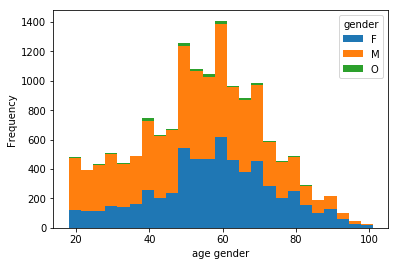

In [253]:
profile_no_nan = profile['gender'].notna()
profile_no_nan =  profile[profile_no_nan]

profile_no_nan.pivot(columns = 'gender',values = 'age').plot.hist(stacked = True,bins=25)
plt.xlabel('age gender')
plt.savefig('profile_age_by_gender.png')

In [254]:
#Quntiti costomer by gender

In [255]:
profile_no_nan.groupby('gender')['gender'].count()

gender
F    6129
M    8484
O     212
Name: gender, dtype: int64

In [256]:
#Transforme data in year
per_year = profile[['id','became_member_on']]
per_year['membership_year'] = profile['became_member_on'].dt.year
per_year_group= per_year.groupby('membership_year').count()['id']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [257]:
per_year_group

membership_year
2013     274
2014     662
2015    1597
2016    3024
2017    5599
2018    3669
Name: id, dtype: int64

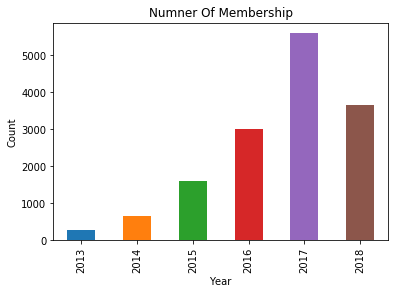

In [258]:
#evolution of members
per_year_group.plot(kind = 'bar')
plt.title('Numner Of Membership')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [259]:
profile.head(2)

,age,became_member_on,gender,id,income
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0


In [260]:
portfolio_dummy.head(2)

,difficulty,duration,id,reward,web,mobile,email,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0


In [261]:
portfolio.head(2)

,difficulty,duration,id,offer_type,reward,web,mobile,email,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


In [262]:
df_transcript.head(2)

,event,person,time,amount,id,offer_completed,offer_received,offer_viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [263]:
#merge between profile_clean and df_transcript
df_transcript_portifolio = df_transcript.merge(profile_clean,how='left',left_on='person',right_on='id',validate='m:1'
                                               ,suffixes=("_transcript", "_profile")).drop(['id_profile'],axis=1)

In [264]:
#Rename column
df_transcript_portifolio.rename(columns={'id_transcript':'id'},inplace=True)

In [265]:
#Create a new column to grouping age in categories (transform continuous in categories)
profile_clean['age_groups'] = pd.cut(profile_clean.age, bins=[0, 12, 18, 21, 64, 200], labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

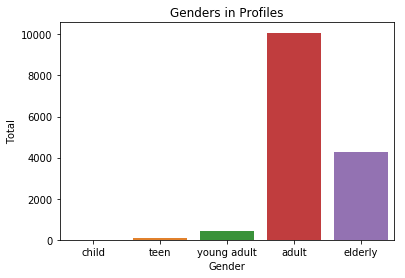

In [266]:
sns.countplot(profile_clean['age_groups'])
plt.title('Genders in Profiles')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

In [267]:
df_transcript_portifolio_plot = df_transcript_portifolio.merge(portfolio,how='left',left_on='id',right_on='id',validate='m:1',suffixes=("_transcript", "_portfolio"))

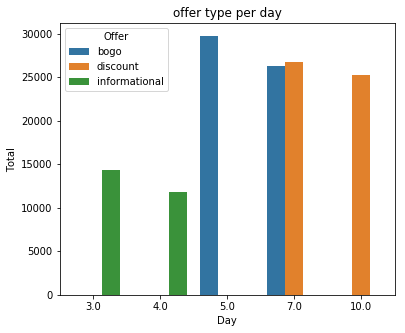

In [268]:
plt.figure(figsize=(6, 5))
sns.countplot(x=df_transcript_portifolio_plot.duration, hue=df_transcript_portifolio_plot.offer_type)
plt.title('offer type per day')
plt.ylabel('Total')
plt.xlabel('Day')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

In [269]:
df_transcript.drop_duplicates(inplace=True)
df_transcript.reset_index(drop=True, inplace=True)
profile_clean.rename(columns={'id':'person'},inplace=True)
df_all = df_transcript


In [270]:
portfolio.head(2)

,difficulty,duration,id,offer_type,reward,web,mobile,email,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


In [271]:
df_all = df_transcript.merge(profile_clean,how='left',left_on='person',right_on='person',validate='m:1')

In [272]:
df_all = df_all.merge(portfolio, how="left", left_on="id", right_on="id", validate="m:1",
                 suffixes=("_transcript", "_portfolio"))

In [273]:
df_transcript_profile=df_all

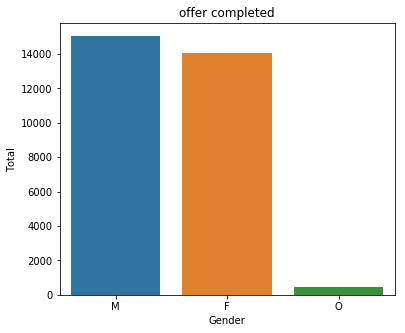

In [274]:
offer_completed = df_transcript_profile[df_transcript_profile.offer_completed == 1]

profile_no_nan = offer_completed['gender'].notna()
profile_no_nan = offer_completed[profile_no_nan]

plt.figure(figsize=(6, 5))
sns.countplot(x=profile_no_nan.gender)
plt.title('offer completed')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

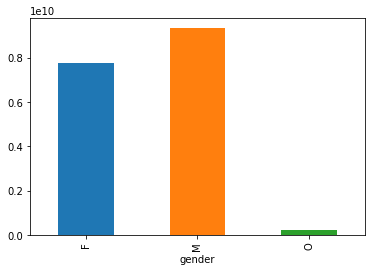

In [275]:
df_all.groupby(['gender']).sum()['income'].plot(kind='bar')

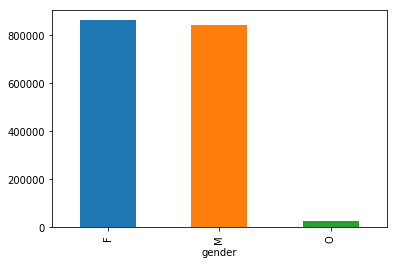

In [276]:
df_all.groupby(['gender']).sum()['amount'].plot(kind='bar')

In [277]:
df_all.groupby(['gender']).sum()['amount']

gender
F    863695.00
M    844890.86
O     26356.54
Name: amount, dtype: float64

In [278]:
df_all.groupby(['gender']).count()['amount']

gender
F    49382
M    72794
O     1781
Name: amount, dtype: int64

In [279]:
list_person_females_completed = list(set(offer_completed[offer_completed.gender == 'F'].person))
list_person_males_completed = list(set(offer_completed[offer_completed.gender == 'M'].person))

In [280]:
df_person_famales_completed = df_all[df_all['person'].isin(list_person_females_completed)]
df_person_males_completed = df_all[df_all['person'].isin(list_person_males_completed)]

In [281]:
completed_all = df_all[df_all['person'].isin(list(set(offer_completed.person)))]

In [282]:
completed_all.shape

(251757, 25)

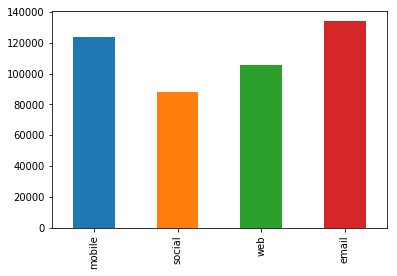

In [283]:
#show distribution channel of offers
df_all[['mobile','social','web','email']].sum().plot(kind='bar')

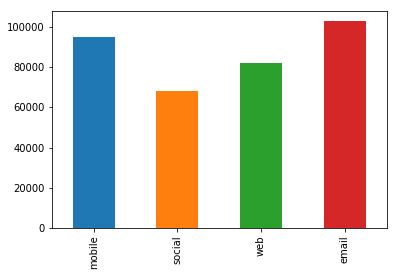

In [284]:
completed_all[['mobile','social','web','email']].sum().plot(kind='bar')

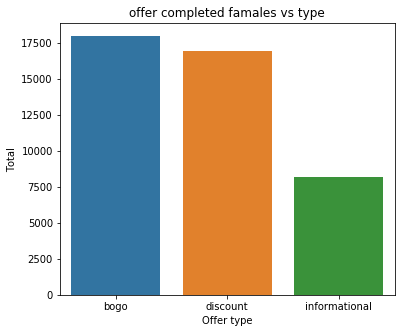

In [285]:
plt.figure(figsize=(6, 5))
sns.countplot(x=df_person_famales_completed.offer_type)
plt.title('offer completed famales vs type')
plt.ylabel('Total')
plt.xlabel('Offer type')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

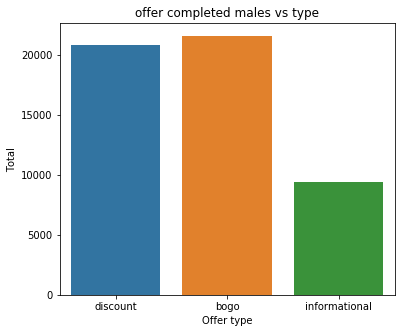

In [286]:
plt.figure(figsize=(6, 5))
sns.countplot(x=df_person_males_completed.offer_type)
plt.title('offer completed males vs type')
plt.ylabel('Total')
plt.xlabel('Offer type')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show()

    Data Modeling

In [287]:
#Agruping to count 
df_final = df_all.groupby(['person','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()

In [288]:
df_final = df_final.pivot(index='person', columns='event', values='count')

In [289]:
df_final.columns = [col.replace(' ', '_') for col in df_final.columns]
#New Colum with proportion complited and received offer
df_final['completed_value'] = df_final.offer_completed / df_final.offer_received
df_final.head(2)

,offer_completed,offer_received,offer_viewed,transaction,completed_value
person,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,0.6
00116118485d4dfda04fdbaba9a87b5c,NaN,2.0,2.0,3.0,NaN


In [290]:
#Drop null
df_final.dropna(inplace=True)
prepared = profile_clean
df_final.head()

,offer_completed,offer_received,offer_viewed,transaction,completed_value
person,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,0.60
0011e0d4e6b944f998e987f904e8c1e5,2.0,5.0,5.0,5.0,0.40
0020c2b971eb4e9188eac86d93036a77,2.0,5.0,3.0,8.0,0.40
0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,4.0,12.0,0.75
003d66b6608740288d6cc97a6903f4f0,3.0,5.0,4.0,18.0,0.60


In [291]:
prepared = pd.merge(profile_clean, df_final[['completed_value']].reset_index(), how='left'
                    , left_on='person', right_on='person')
prepared['answer'] = prepared.person.isin(df_final.index).astype(int)
#fill with  0 
prepared.completed_value.fillna(0, inplace=True)
prepared.dropna(inplace=True)

In [292]:
#Remove column
prepared.drop('person',axis=1,inplace=True)
prepared.head(2)

,age,became_member_on,gender,income,F,M,O,age_groups,completed_value,answer
0,55,2017-07-15,F,112000.0,1,0,0,adult,0.0,0
1,75,2017-05-09,F,100000.0,1,0,0,elderly,0.5,1


In [293]:
#Create other shape to income column (continuous -> categorical)
prepared['income'] = pd.cut(prepared['income'], 
          bins=[prepared['income'].min(), 40000, 60000, 80000,100000, prepared['income'].max()], 
          labels = ['<40k', '40k~60k', '60k~80k', '80k~100k', '>100k'])

In [294]:
prepared.head(2)

,age,became_member_on,gender,income,F,M,O,age_groups,completed_value,answer
0,55,2017-07-15,F,>100k,1,0,0,adult,0.0,0
1,75,2017-05-09,F,80k~100k,1,0,0,elderly,0.5,1


In [295]:
#Transforme  became_member_on in days
prepared.became_member_on = pd.to_datetime(prepared.became_member_on, format='%Y%m%d')
recent = max(prepared.became_member_on)
prepared['membership in_days'] = prepared.became_member_on.apply(lambda x: recent - x).dt.days
prepared.drop('became_member_on',axis=1,inplace=True)

In [296]:
prepared.head(2)

,age,gender,income,F,M,O,age_groups,completed_value,answer,membership in_days
0,55,F,>100k,1,0,0,adult,0.0,0,376
1,75,F,80k~100k,1,0,0,elderly,0.5,1,443


In [297]:
# Split customers data into X and y
X = pd.get_dummies(prepared[['income','gender','age','membership in_days']])
y = prepared['answer']

In [298]:
def show_score(y_test,y_pred,nameModel):
    """
    y_test:
    y_pred:
    nameModel: Name of model
    Show metrics of models
    """
    print('Metrics of model:' +nameModel)
    print(classification_report(y_test, y_pred))

In [299]:
# Set discount_response as the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train three models
log_reg = LogisticRegression().fit(X_train, y_train)
rfc = RandomForestClassifier().fit(X_train, y_train)
adaboost = AdaBoostClassifier().fit(X_train, y_train)

In [300]:
y_pred = log_reg.predict(X_test)
show_score(y_test,y_pred,'LogisticRegression')

y_pred = rfc.predict(X_test)
show_score(y_test,y_pred,'RandomForestClassifier')

y_pred = adaboost.predict(X_test)
show_score(y_test,y_pred,'AdaBoostClassifier')


Metrics of model:LogisticRegression
             precision    recall  f1-score   support

          0       0.62      0.08      0.14       883
          1       0.81      0.99      0.89      3565

avg / total       0.77      0.81      0.74      4448

Metrics of model:RandomForestClassifier
             precision    recall  f1-score   support

          0       0.38      0.32      0.35       883
          1       0.84      0.87      0.85      3565

avg / total       0.75      0.76      0.75      4448

Metrics of model:AdaBoostClassifier
             precision    recall  f1-score   support

          0       0.54      0.19      0.28       883
          1       0.83      0.96      0.89      3565

avg / total       0.77      0.81      0.77      4448



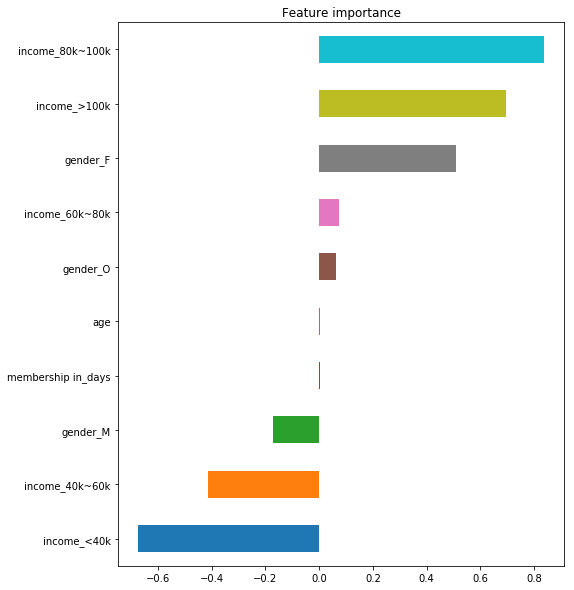

In [301]:
def show_coef(model,X):
    """
    model: model
    X: dataFrame with fields
    Show feature importance
    """
    coef = pd.Series(model.coef_[0], index = X.columns)
    imp_coef = coef.sort_values()
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance")
    
show_coef(log_reg,X)

In [302]:
def show_feature_importances(columns,modelo,nameModel):
    """
    columns : columns of dataframe used
    model: model
    nameModel: name of model
    Show feature importance
    """
    features = columns
    importances = modelo.feature_importances_
    indices = np.argsort(importances)

    plt.title(nameModel)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()


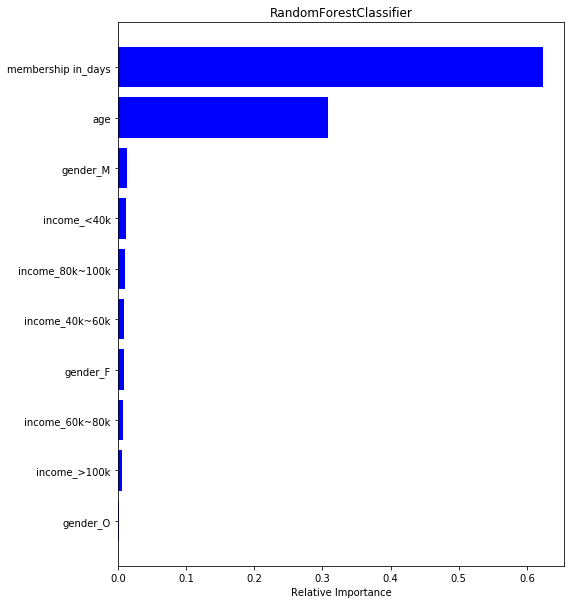

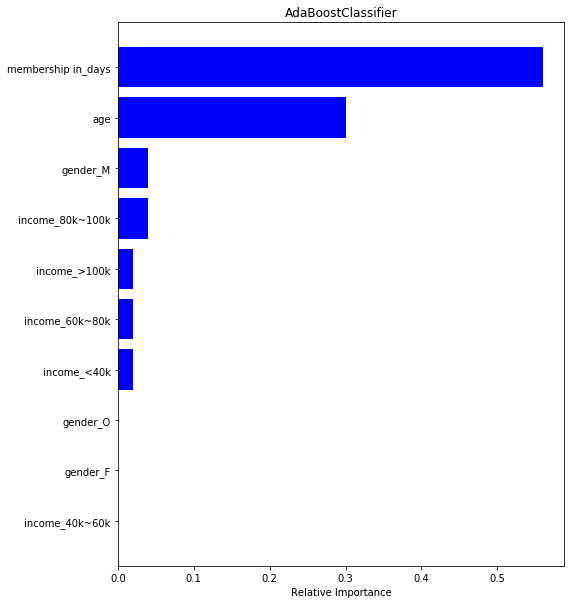

In [303]:
show_feature_importances(X.columns,rfc,'RandomForestClassifier')
show_feature_importances(X.columns,adaboost,'AdaBoostClassifier')

In [304]:
#Impruve model

In [305]:
from sklearn.model_selection import GridSearchCV

In [306]:
parameters = {}

In [307]:
clf_log_reg=GridSearchCV(LogisticRegression(), parameters)
clf_log_reg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [308]:
parameters = {'C':[1.0],'penalty':['l2']}

In [309]:
clf_log_reg=GridSearchCV(LogisticRegression(), parameters)
clf_log_reg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1.0], 'penalty': ['l2']}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [310]:

y_pred = clf_log_reg.predict(X_test)
show_score(y_test,y_pred,'LogisticRegression')

Metrics of model:LogisticRegression
             precision    recall  f1-score   support

          0       0.62      0.08      0.14       883
          1       0.81      0.99      0.89      3565

avg / total       0.77      0.81      0.74      4448



In [311]:
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [312]:
parameters = {
    'n_estimators': [15, 35, 55],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

In [313]:
adaboost = GridSearchCV(AdaBoostClassifier(), param_grid=parameters)
adaboost.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [15, 35, 55], 'learning_rate': [0.1, 0.5, 1], 'algorithm': ['SAMME', 'SAMME.R']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [314]:
y_pred = adaboost.predict(X_test)
show_score(y_test,y_pred,'AdaBoostClassifier')

Metrics of model:AdaBoostClassifier
             precision    recall  f1-score   support

          0       0.59      0.11      0.18       883
          1       0.82      0.98      0.89      3565

avg / total       0.77      0.81      0.75      4448



In [315]:
parameters = {'max_depth':[7]}

In [316]:
rfc=GridSearchCV(RandomForestClassifier(), parameters)
rfc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={'max_depth': [7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [317]:
rfc.best_params_

{'max_depth': 7}

In [318]:
y_pred = rfc.predict(X_test)
show_score(y_test,y_pred,'RandomForestClassifier')

Metrics of model:RandomForestClassifier
             precision    recall  f1-score   support

          0       0.53      0.13      0.21       883
          1       0.82      0.97      0.89      3565

avg / total       0.76      0.80      0.75      4448



    Conclusions

    I tried to identify the most consumed audience and which channels
    - Men and women respond best to bogo offer.
    - Men buy more than women but when we add these values, we find that women spend more than men.
    - Both in general and in completed offers, the email channel was the most accepted

    Creating a model

    My goal is to create a model that can identify whether or not a given customer will respond to an offer, so I made use of the following models:(RandomForestClassifier,AdaBoostClassifier e LogisticRegression).
    
    
    The Starbucks need to invest in offers for women as they will generate more profitability for the company, even if their income is lower compared to men 


